In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [2]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")
# test_data_raw = np.loadtxt(open("../Datasets/mnist_test.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]
# test_data = test_data_raw[:, 1:]
# test_labels = test_data_raw[:, 0]

In [3]:
# Data normalization
train_data_norm = train_data / np.max(train_data)
# test_data_norm = test_data / np.max(test_data)


# preserving the re-ordering for each image
eggs = np.random.permutation(train_data_norm.shape[1])
scrambled = train_data_norm[:, eggs]


# scrambledIndex_test = np.random.permutation(test_data_norm.shape[1])
# scrambled_test = test_data_norm[:, scrambledIndex_test]


print(np.min(train_data_norm), np.max(scrambled))
# print(np.min(test_data_norm), np.max(scrambled_test))

0.0 1.0


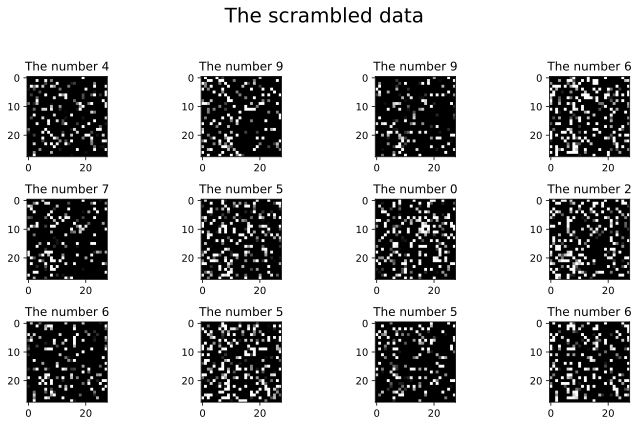

In [4]:
# show a few random digits
fig, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
    # pick a random image
    randimg2show = np.random.randint(0, high=train_data.shape[0])

    # create the image (must be reshaped!)
    img = np.reshape(scrambled[randimg2show, :], (28, 28))
    ax.imshow(img, cmap="gray")

    # title
    ax.set_title("The number %i" % train_labels[randimg2show])

plt.suptitle("The scrambled data", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [5]:
### Create train and test groups using dataloader
# Convert to tensor
train_data_tensor = torch.tensor(scrambled).float()
train_labels_tensor = torch.tensor(train_labels).long()
# test_data_tensor = torch.tensor(scrambled_test).float()
# test_labels_tensor = torch.tensor(test_labels).long()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    train_data_tensor, train_labels_tensor, test_size=0.1
)

# Convert into pytorch dataset
train_dataT = TensorDataset(train_data, train_labels)
test_dataT = TensorDataset(test_data, test_labels)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [6]:
# Create the model function
def createNewMNISTNet(lr=0.01):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784, 64)

            # Hidden Layers
            self.hidden1 = nn.Linear(64, 32)
            self.hidden2 = nn.Linear(32, 32)

            # Output Layer
            self.output = nn.Linear(32, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            return self.output(x)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    return net, lossFun, optimizer

In [7]:
# Function to train the model
nEpochs = 30


def trainTheModel():
    net, lossFun, optimizer = createNewMNISTNet(lr=0.01)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append(
            100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
        )
    # End of epoch

    return trainAcc, testAcc, losses, net

In [8]:
trainAcc, testAcc, losses, net = trainTheModel()

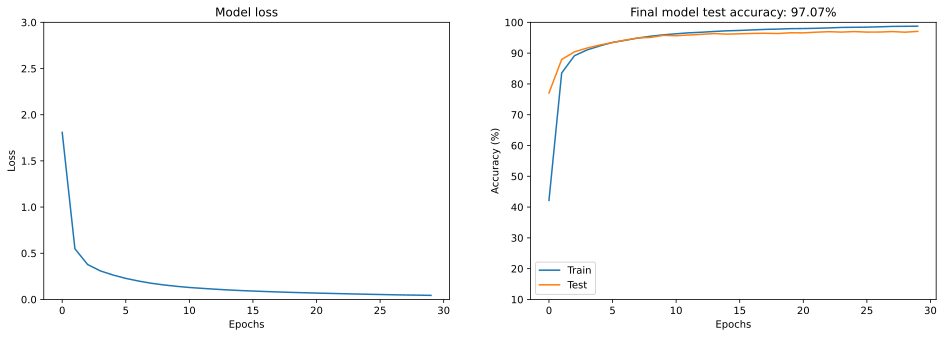

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [10]:
# 1) We scrambled all images using the same permuted index. What would happen if each image is uniquely
#    randomly scrambled? Rewrite the scrambling code so that each individual stimulus has a unique,
#    random permuted index. What do the results show and why is that the case?
#